In [8]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib qt
%matplotlib inline

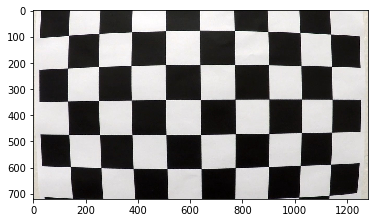

In [9]:
I = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(I)

In [10]:
image_files = glob.glob('camera_cal/calibration*.jpg')

In [11]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

object_points =[]
corner_points = []
for image_file in image_files:
    img = mpimg.imread(image_file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img_gray, (9,6), None)
    
    if ret:
        object_points.append(objp)
        corner_points.append(corners)
#         final_img = cv2.drawChessboardCorners(img, (6,9), corners, ret)
#         plt.imshow(final_img)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, corner_points, img_gray.shape[::-1], None, None)

# img_undist = cv2.undistort(img, mtx, dist, None, mtx)

In [12]:
class Advanced_Lane_Detection:
    def __init__(self):
        crop_vertex1 = [200, 0] 
        crop_vertex2 = [300, 719]
        crop_vertex3 = [900, 719]
        crop_vertex4 = [1000, 0]
        self.crop_vertices = np.array([[crop_vertex1, crop_vertex2, crop_vertex3, crop_vertex4]])
        
        tl = [595, 447]
        tr = [685, 447]
        bl = [270, 673]
        br = [1037, 673]
        src = np.float32([tl, bl, br, tr])
        dst = np.float32([[400,100], [400, 700], [800,700], [800,100]])
        self.M = cv2.getPerspectiveTransform(src, dst)
        
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/200 # meters per pixel in x dimension
    
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        object_points =[]
        corner_points = []
        for image_file in image_files:
            img = mpimg.imread(image_file)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(img_gray, (9,6), None)
            if ret:
                object_points.append(objp)
                corner_points.append(corners)

        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(object_points, corner_points, img_gray.shape[::-1], None, None)
    
    def pipeline(image):
        Image = self.undistort_image(image)

In [13]:
def undistort_image(self, image):
    undistorted_image = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    return undistorted_image

In [14]:
def sobel_mag_thresh(self, image, mag_thresh=(30, 100), sobel_kernel=3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    xderiv = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    yderiv = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abso = np.sqrt(np.square(xderiv) + np.square(yderiv))
    img8 = np.uint8((abso/np.max(abso))*255)
    binary = np.zeros_like(img8)
    binary[(img8 >= mag_thresh[0]) & (img8 <= mag_thresh[1])] = 1
    return binary

In [15]:
def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    xderiv = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    yderiv = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    xabso = np.absolute(xderiv)
    yabso = np.absolute(yderiv)
    direction = np.arctan2(yabso, xabso)
    binary = np.zeros_like(direction)
    binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary

In [16]:
def sat_threshold(self, img, thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    mask = np.zeros_like(s)
    mask[(s > thresh[0]) & (s <= thresh[1])] = 1
    return mask

In [17]:
def hue_threshold(self, img, thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    mask = np.zeros_like(h)
    mask[(h > thresh[0]) & (h <= thresh[1])] = 1
    return mask

In [18]:
def crop_top_view(self, img):
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    if len(img.shape) > 2:
        ignore_mask_color = [255]*img.shape[2]  
    cv2.fillPoly(mask, self.crop_vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [19]:
def top_view_perspective(self, img):
    return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]))

In [20]:
def get_lane_position_estimate(self, img):
    bottom_third = img[int(img.shape[0]/3):,:]
    histogram = np.sum(bottom_third, axis=0)
    mid_point = int(len(histogram)/2)
    left_lane_position = np.argmax(histogram[:mid_point])
    right_lane_position = mid_point + np.argmax(histogram[mid_point:])
    return left_lane_position, right_lane_position

In [21]:
def compute_lane_prior(self, processed_img, display=False):
    if display:
        disp_img = np.dstack((processed_img, np.zeros_like(processed_img), np.zeros_like(processed_img)))*255
    min_active_px = 50
    windows = 10
    win_width = 200
    win_height = 50
    win_base = processed_img.shape[0]
    left_lane_indxs = np.array([])
    right_lane_indxs = np.array([])
    
    active_px_rows, active_px_cols = processed_img.nonzero()
    left_lane_position, right_lane_position = self.get_lane_position_estimate(processed_img)
    while win_base >= win_height:
        LL_left_edge = left_lane_position - win_width/2
        LL_right_edge = left_lane_position + win_width/2
        RL_left_edge = right_lane_position - win_width/2
        RL_right_edge = right_lane_position + win_width/2
        
        if display:
            cv2.rectangle(disp_img, (int(LL_left_edge),win_base), (int(LL_right_edge),win_base-50), (255,255,255), 2)
            cv2.rectangle(disp_img, (int(RL_left_edge),win_base), (int(RL_right_edge),win_base-50), (255,255,255), 2)
        
        left_active_indx = ((active_px_rows <= win_base) & (active_px_rows > win_base - win_height) &
                            (active_px_cols >= LL_left_edge) & (active_px_cols <= LL_right_edge)).nonzero()[0]
        right_active_indx = ((active_px_rows <= win_base) & (active_px_rows > win_base - win_height) &
                            (active_px_cols >= RL_left_edge) & (active_px_cols <= RL_right_edge)).nonzero()[0]
        
        if len(left_active_indx) > min_active_px:
            left_lane_position = int(np.mean(active_px_cols[left_active_indx]))
        if len(right_active_indx) > min_active_px:
            right_lane_position = int(np.mean(active_px_cols[right_active_indx]))
        
        left_lane_indxs = np.append(left_lane_indxs, left_active_indx)
        right_lane_indxs = np.append(right_lane_indxs, right_active_indx) 
        win_base -= 50
        
    left_lane_pixel_y = active_px_rows[left_lane_indxs.astype(int)]
    left_lane_pixel_x = active_px_cols[left_lane_indxs.astype(int)]
    
    right_lane_pixel_y = active_px_rows[right_lane_indxs.astype(int)]
    right_lane_pixel_x = active_px_cols[right_lane_indxs.astype(int)]
    
    left_lane_function = np.poly1d(np.polyfit(left_lane_pixel_y, left_lane_pixel_x, 2))
    right_lane_function = np.poly1d(np.polyfit(right_lane_pixel_y, right_lane_pixel_x, 2))

    left_lane_curve = self.compute_real_curvature(left_lane_pixel_y, left_lane_pixel_x, processed_img.shape[0])
    right_lane_curve = self.compute_real_curvature(right_lane_pixel_y, right_lane_pixel_x, processed_img.shape[0])
            
    if display:
        Y = np.array(range(processed_img.shape[0]))
        plt.imshow(disp_img)
        plt.plot(left_lane_function(Y), Y, (0, 255, 255))
        plt.plot(right_lane_function(Y), Y, (0, 255, 255))
        show_window(self, processed_img, left_lane_function, right_lane_function, 100)
    
    return left_lane_function, right_lane_function, left_lane_curve, right_lane_curve

In [22]:
def find_lane(self, processed_img, prior_left_lane_function, prior_right_lane_function, margin, display=False):
        active_px_rows, active_px_cols = processed_img.nonzero()

        left_lane_indxs = ((active_px_cols >= prior_left_lane_function(active_px_cols) - margin) & 
                           (active_px_cols <= prior_left_lane_function(active_px_cols) + margin)).nonzero()[0]
        
        right_lane_indxs = ((active_px_cols >= prior_right_lane_function(active_px_cols) - margin) & 
                           (active_px_cols <= prior_right_lane_function(active_px_cols) + margin)).nonzero()[0]
        
        left_lane_pixel_y = active_px_rows[left_lane_indxs.astype(int)]
        left_lane_pixel_x = active_px_cols[left_lane_indxs.astype(int)]

        right_lane_pixel_y = active_px_rows[right_lane_indxs.astype(int)]
        right_lane_pixel_x = active_px_cols[right_lane_indxs.astype(int)]
        
        left_lane_function = np.poly1d(np.polyfit(left_lane_pixel_y, left_lane_pixel_x, 2))
        right_lane_function = np.poly1d(np.polyfit(right_lane_pixel_y, right_lane_pixel_x, 2))
        
        left_lane_curve = self.compute_real_curvature(left_lane_pixel_y, left_lane_pixel_x, processed_img.shape[0])
        right_lane_curve = self.compute_real_curvature(right_lane_pixel_y, right_lane_pixel_x, processed_img.shape[0])
        
        if display:
            show_window(self, processed_img, left_lane_function, right_lane_function, 100,
                       prior_left_lane_function, prior_right_lane_function)
            
        return left_lane_function, right_lane_function, left_lane_curve, right_lane_curve

In [23]:
def compute_real_curvature(self, y_pxs, x_pxs, y):
    A, B, C = np.polyfit(y_pxs*self.ym_per_pix, x_pxs*self.xm_per_pix, 2)
    curvature = ((1 + (2*A*y + B)**2)**(3/2))/abs(2*A)
    return curvature

In [24]:
def compute_pos_from_center(self, left_lane_fn, right_lane_fn, image_height):
    veh_center = (left_lane_fn(image_height-1) + right_lane_fn(image_height-1))/2
    deviation_cm = (veh_center - 600)*self.xm_per_pix*100
    return deviation_cm

In [25]:
def image_pipeline(self, image):
    image_undistorted = self.undistort_image(image)

    image_sob_thresh = self.sobel_mag_thresh(image_undistorted, mag_thresh=(70, 255), sobel_kernel=17)
    
    image_dir_thresh = self.dir_threshold(image_undistorted, sobel_kernel=17, thresh=(0, 1.2))
    
    gradient_binary = np.zeros_like(image_dir_thresh) 
    gradient_binary[(image_sob_thresh == 1) & (image_dir_thresh == 1)] = 1
    
    image_sat_thresh = self.sat_threshold(image_undistorted, (100,255))
    
    image_hue_thresh = self.hue_threshold(img, (0,100))

    color_thresh_binary = np.zeros_like(image_hue_thresh)
    color_thresh_binary[(image_sat_thresh == 1) & (image_hue_thresh == 1)] = 1

    image_compound_binary = np.zeros_like(color_thresh_binary)
    image_compound_binary[(gradient_binary == 1) | (color_thresh_binary == 1)] = 1

    image_processed_top_view = self.top_view_perspective(image_compound_binary)
    image_final = self.crop_top_view(image_processed_top_view)

    return image_final

In [26]:
def show_window(self, processed_img, left_fn, right_fn, margin, left_fn2=None, right_fn2=None):
    window_img_1d = np.zeros_like(processed_img)
    window_img = np.dstack((window_img_1d, window_img_1d, window_img_1d))
    base_img = np.dstack((processed_img, window_img_1d, window_img_1d))*255
    ploty = np.array(range(processed_img.shape[0]))
    
    left_fitx = left_fn(ploty)
    right_fitx = right_fn(ploty)
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

    if left_fn2 and right_fn2:
        window_img_2 = np.dstack((window_img_1d, window_img_1d, window_img_1d))
        
        left_fitx = left_fn2(ploty)
        right_fitx = right_fn2(ploty)

        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        cv2.fillPoly(window_img_2, np.int_([left_line_pts]), (0, 0, 255))
        cv2.fillPoly(window_img_2, np.int_([right_line_pts]), (0, 0, 255))

        plt.plot(left_fn(ploty), ploty, (0, 0, 255))
        plt.plot(right_fn(ploty), ploty, (0, 0, 255))
        
        window_img = cv2.addWeighted(window_img, 1, window_img_2, 0.8, 0)
        
    result = cv2.addWeighted(base_img, 1, window_img, 0.3, 0)
    plt.imshow(result)

In [27]:
ALD.compute_lane_prior(pipeline_final_image, display=True)

NameError: name 'ALD' is not defined

In [ ]:
l,r,lc,rc = ALD.find_lane(pipeline_final_image, l, r, 100, display=True)

In [ ]:
ALD.compute_pos_from_center(l, r, pipeline_final_image.shape[0])

In [ ]:
Advanced_Lane_Detection.undistort_image = undistort_image
Advanced_Lane_Detection.sobel_mag_thresh = sobel_mag_thresh
Advanced_Lane_Detection.dir_threshold = dir_threshold
Advanced_Lane_Detection.sat_threshold = sat_threshold
Advanced_Lane_Detection.hue_threshold = hue_threshold
Advanced_Lane_Detection.crop_top_view = crop_top_view
Advanced_Lane_Detection.top_view_perspective = top_view_perspective
Advanced_Lane_Detection.image_pipeline = image_pipeline

Advanced_Lane_Detection.get_lane_position_estimate = get_lane_position_estimate
Advanced_Lane_Detection.compute_lane_prior = compute_lane_prior
Advanced_Lane_Detection.find_lane = find_lane
Advanced_Lane_Detection.compute_real_curvature = compute_real_curvature
Advanced_Lane_Detection.compute_pos_from_center = compute_pos_from_center

Advanced_Lane_Detection.show_window = show_window

ALD = Advanced_Lane_Detection()


In [ ]:
img = mpimg.imread('test_images/test1.jpg')
pipeline_final_image = ALD.image_pipeline(img)

plt.imshow(pipeline_final_image, cmap='gray')

In [ ]:
ALD = Advanced_Lane_Detection()

NameError: name 'ALD' is not defined

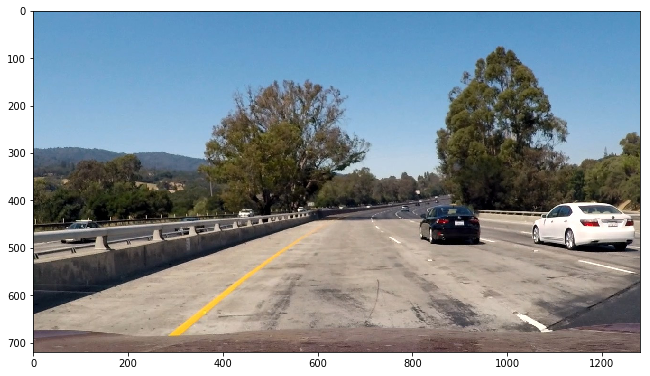

In [28]:
fig = plt.figure(figsize=(50, 25))
img = mpimg.imread('test_images/test1.jpg')
# img = mpimg.imread('test_images/straight_lines1.jpg')
fig.add_subplot(3,4,1)
plt.imshow(img)

img_udt = ALD.undistort_image(img)
fig.add_subplot(3,4,2)
plt.imshow(img_udt)

sob_fil = ALD.sobel_mag_thresh(img_udt, mag_thresh=(70, 255), sobel_kernel=17)
fig.add_subplot(3,4,3)
plt.imshow(sob_fil, cmap='gray')

dt = ALD.dir_threshold(img, sobel_kernel=17, thresh=(0, 1.2))
gradient_binary = np.zeros_like(sob_fil)
gradient_binary[(sob_fil == 1) & (dt == 1)] = 1
fig.add_subplot(3,4,4)
plt.imshow(gradient_binary, cmap='gray')

sat_thr = ALD.sat_threshold(img, (100,255))
fig.add_subplot(3,4,5)
plt.imshow(sat_thr, cmap='gray')

hue_thr = ALD.hue_threshold(img, (0,100))
fig.add_subplot(3,4,6)
plt.imshow(hue_thr, cmap='gray')

color_thresh_binary = np.zeros_like(sat_thr)
color_thresh_binary[(sat_thr == 1) & (hue_thr == 1)] = 1
fig.add_subplot(3,4,7)
plt.imshow(color_thresh_binary, cmap='gray')

color_thresh = np.dstack((sat_thr, hue_thr, np.zeros_like(sat_thr)))*255
fig.add_subplot(3,4,8)
plt.imshow(color_thresh)

components = np.dstack((gradient_binary, color_thresh_binary, np.zeros_like(sat_thr)))*255
fig.add_subplot(3,4,9)
plt.imshow(components)
comp_binary = np.zeros_like(color_thresh_binary)
comp_binary[(gradient_binary == 1) | (color_thresh_binary == 1)] = 1
fig.add_subplot(3,4,10)
plt.imshow(comp_binary, cmap='gray')

warped = ALD.top_view_perspective(comp_binary)
top_view_processed_img = ALD.crop_top_view(warped)
fig.add_subplot(3,4,11)
plt.imshow(top_view_processed_img, cmap='gray')


In [ ]:
warped = ALD.top_view_perspective(components)
cw = ALD.crop_top_view(warped)
plt.imshow(cw, cmap='gray')

In [ ]:
plt.imshow(warped, cmap='gray')

In [ ]:
plt.imshow(comp_binary, cmap='gray')

In [ ]:
%matplotlib inline
img = mpimg.imread('test_images/test2.jpg')
dt = ALD.dir_threshold(img, sobel_kernel=17, thresh=(0, 1.2))
plt.imshow(dt, cmap='gray')

In [ ]:
%matplotlib qt
img = mpimg.imread('test_images/tes1.jpg')
print(img.shape)
# sob_fil = ALD.sat_threshold(img, (140,255))
# fig = plt.figure(figsize=(10, 10))
plt.imshow(img)

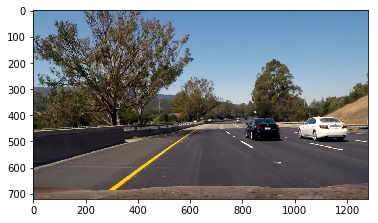

In [36]:
%matplotlib inline
img = mpimg.imread('test_images/test6.jpg')
# sob_fil = ALD.sat_threshold(img, (140,255))
# fig = plt.figure(figsize=(40, 40))
plt.imshow(img)

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
class AA:
    def nting(self, img):
        return img
        
A = AA()

In [5]:
clip1 = VideoFileClip("challenge_video.mp4")
white_output = 'trial.mp4'
white_clip = clip1.fl_image(A.nting) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video trial.mp4
[MoviePy] Writing video trial.mp4


100%|██████████| 485/485 [00:45<00:00, 10.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: trial.mp4 

CPU times: user 1.08 s, sys: 1.21 s, total: 2.3 s
Wall time: 48.3 s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))